### Import packages

In [3]:
library(GWmodel)      ### GW models
library(dplyr)
library(sp)           ## Data management
library(car)          ## vif
library(spdep)        ## Spatial autocorrelation
library(RColorBrewer) ## Visualization
library(classInt)     ## Class intervals
library(raster)       ## spatial data
library(grid)         # plot
library(gridExtra)    # Multiple plot
library(ggplot2)      # Multiple plot
library(gtable)
library(GGally)       # 相關係數圖矩陣（scatter plot matrix）
library(maptools)
library(MASS)
library(tmap)

載入需要的套件：maptools

載入需要的套件：sp

Checking rgeos availability: TRUE

載入需要的套件：robustbase

載入需要的套件：Rcpp

載入需要的套件：spatialreg

載入需要的套件：spData

載入需要的套件：Matrix

載入需要的套件：sf

Linking to GEOS 3.9.0, GDAL 3.2.1, PROJ 7.2.1

Welcome to GWmodel version 2.2-8.


載入套件：'dplyr'


下列物件被遮斷自 'package:stats':

    filter, lag


下列物件被遮斷自 'package:base':

    intersect, setdiff, setequal, union


載入需要的套件：carData


載入套件：'car'


下列物件被遮斷自 'package:dplyr':

    recode



載入套件：'spdep'


下列物件被遮斷自 'package:spatialreg':

    aple, aple.mc, aple.plot, as.spam.listw, as_dgRMatrix_listw,
    as_dsCMatrix_I, as_dsCMatrix_IrW, as_dsTMatrix_listw,
    can.be.simmed, cheb_setup, create_WX, do_ldet, eigen_pre_setup,
    eigen_setup, eigenw, errorsarlm, get.ClusterOption,
    get.coresOption, get.mcOption, get.VerboseOption,
    get.ZeroPolicyOption, GMargminImage, GMerrorsar, griffith_sone,
    gstsls, Hausman.test, impacts, intImpacts, invIrM, invIrW,
    Jacobian_W, jacobianSetup, l_max, lagmess, lagsarlm, lextrB,
    lextrS

### Function

#### pdf_plot

In [4]:

pdf_plot <- function(x){
  g = ggplot()+
    geom_histogram(aes(x = x, y = ..density..), 
                   fill = '#557C55', alpha = 0.8)+
    geom_density(aes(x = x, y = ..density..), 
                 color = '#062C30', size = 1)+
    theme_bw()
  
  return(g)
}


### Load datas

In [92]:
getwd()
path = '..\\..\\Roaming-Dogs-Data\\'
Variable_KS_df <- read.csv(paste0(path, "@Test_KS\\Variable.csv" ), fileEncoding = 'utf-8')
Variable_KS_df["Clinic"][is.na(Variable_KS_df["Clinic"])] = 0
Variable_KS_shp<-st_read(paste0(path, "@Test_KS\\Variable.shp" ))
Variable_KS_centroid <-  st_centroid(Variable_KS_shp)
colnames(Variable_KS_centroid)

ncol(Variable_KS_shp); nrow(Variable_KS_shp)

[1] "c:/@@Roaming_Dogs_Data_Analysis/Roaming-Dogs-Code/Model-fitting"

Reading layer `Variable' from data source 
  `C:\@@Roaming_Dogs_Data_Analysis\Roaming-Dogs-Data\@Test_KS\Variable.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 58 features and 56 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 120.1902 ymin: 22.47035 xmax: 120.557 ymax: 22.97208
Geodetic CRS:  WGS 84


Warning message in st_centroid.sf(Variable_KS_shp):
"st_centroid assumes attributes are constant over geometries of x"


[1] "Market"     "COUNTYNAME" "TOWNNAME"   "VILLNAME"   "VILLENG"   
 [6] "COUNTYID"   "COUNTYCODE" "TOWNID"     "TOWNCODE"   "NOTE"      
[11] "Cluster"    "high_rat"   "mid_rat"    "low_rat"    "high_edu"  
[16] "mid_edu"    "low_edu"    "Hospital_1" "Hospital_2" "Hospital_3"
[21] "Hospital_4" "M_F_RAT"    "P_H_CNT"    "P_DEN"      "DEPENDENCY"
[26] "YOUN_DEP"   "OLD_DEP"    "AGING_IDX"  "H_CNT"      "P_CNT"     
[31] "M_CNT"      "F_CNT"      "Ele"        "Ele_stu"    "Junior"    
[36] "Junior_stu" "Senior"     "Senior_stu" "TaxPayer"   "Income_tot"
[41] "Income_mea" "Income_med" "Income_Q1"  "Income_Q3"  "Income_sta"
[46] "Income_CV"  "Temple"     "Train.stat" "Train.crow" "Hospital"  
[51] "Clinic"     "Area"       "country"    "town"       "village"   
[56] "Nt"         "geometry"

[1] 57

[1] 58

### Create a residual dataframe

In [98]:
residual  <-  
data.frame(VILLCODE = Variable_KS_df$VILLCODE,
VILLNAME = Variable_KS_df$VILLNAME,
geometry = Variable_KS_centroid$geometry )

### select Xy

In [7]:
col_X = c( "Market","Cluster","high_rat",   "mid_rat","low_rat","Hospital" ,  "Clinic", "M_F_RAT" ,
           "P_DEN",      "DEPENDENCY", "YOUN_DEP",   "OLD_DEP",    "AGING_IDX","Ele" ,"Ele_stu","Junior" ,   
           "Junior_stu", "Senior",     "Senior_stu", "TaxPayer" ,  "Income_tot", "Income_mea",
           "Income_med" ,"Income_Q1",  "Income_Q3",  "Income_sta", "Income_CV",  "Temple",    
           "Train.stat", "Train.crow" )
col_y = c('Nt')

In [8]:
crs(Variable_KS_shp)  <-  CRS('+init=EPSG:4326')
(crs(Variable_KS_shp))

CRS arguments: +proj=longlat +datum=WGS84 +no_defs 

#### Correlation 

In [9]:
corr = cor(Variable_KS_df[c(col_y,col_X)])
col_income = c( "Income_mea","Income_med" ,"Income_Q1", 
                "Income_Q3",  "Income_sta", "Income_CV")
corr_income = sort(corr[col_income,'Nt'])
idx = abs(corr[,'Nt'])>.15
col_X_02 = names(corr[idx,'Nt']) %>% tail(-1)

### GLM_POISSON 

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows


Call:
glm(formula = Nt ~ ., family = poisson(), data = Variable_KS_df[, 
    c(col_y, col_X_02)])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9864  -1.2933  -0.3625   1.1794   4.2733  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.176e+00  2.285e+00  -1.390   0.1646    
Cluster      1.116e-01  1.412e-01   0.790   0.4294    
high_rat     5.423e-01  1.626e+00   0.334   0.7387    
low_rat     -2.352e+00  1.264e+00  -1.860   0.0629 .  
M_F_RAT      6.121e-02  1.118e-02   5.473 4.42e-08 ***
P_DEN       -6.263e-05  6.393e-06  -9.797  < 2e-16 ***
DEPENDENCY   1.316e+01  8.705e+00   1.512   0.1306    
YOUN_DEP    -1.325e+01  8.708e+00  -1.521   0.1282    
OLD_DEP     -1.326e+01  8.705e+00  -1.523   0.1278    
Ele          7.775e-01  9.583e-02   8.113 4.94e-16 ***
Income_mea  -1.561e-02  6.160e-03  -2.534   0.0113 *  
Income_med   3.891e-03  3.931e-03   0.990   0.3223    
Income_Q1    1.068e-03  3.186e-03   0.335   0.7374    
In

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



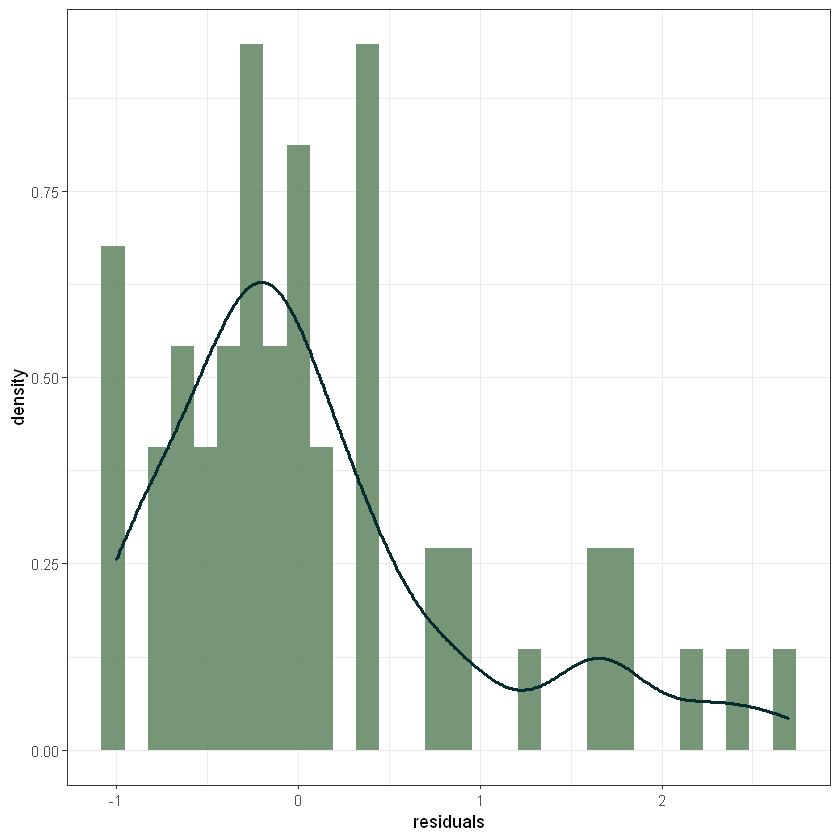

In [14]:
Fit_Po <-glm(Nt~.,data=Variable_KS_df[,c(col_y,col_X_02)],family=poisson())
# Fit_Po <- glm(Nt~., data=Variable_KS_df[,c(col_y,col_X_02)], family = Gamma(link = "log"))
summary(Fit_Po) #查看回归模型参数
pdf_plot(Fit_Po$residuals)+xlab('residuals')

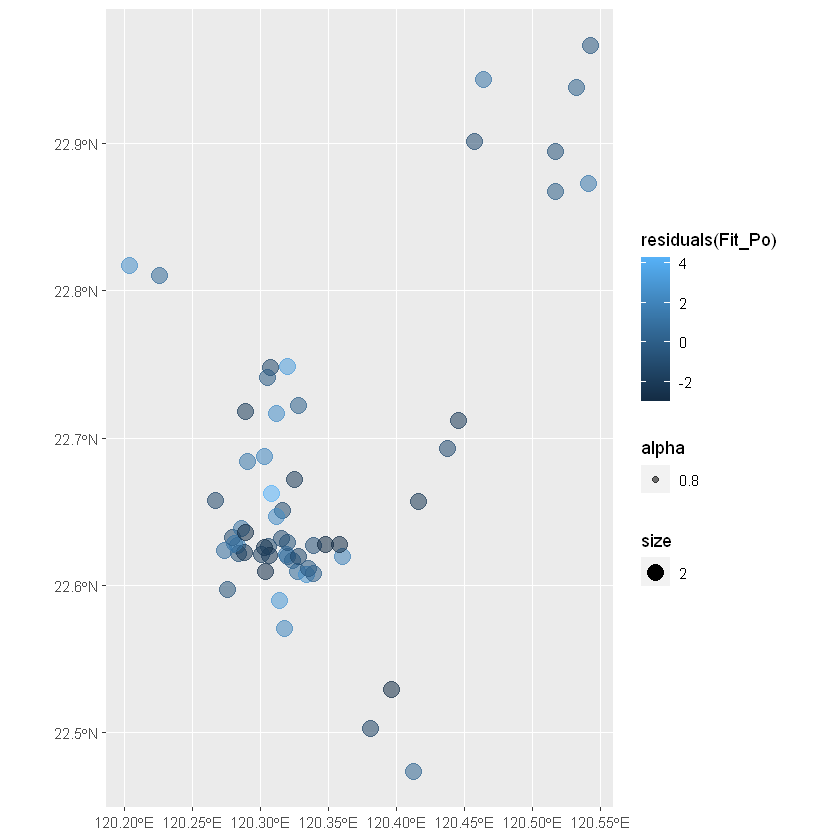

In [122]:
Variable_KS_centroid %>% 
  ggplot()+geom_sf(aes(color = residuals(Fit_Po), size = 2, alpha = .8))